# Image Caption Generator using CNN & LSTM

# Part 1: Processing the Captions

In [1]:
# Imports
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3

from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# Parameters
START = "startseq"
STOP = "endseq"
EPOCHS = 10
root_captioning = ""
training_size = 6000
img_vec_size = 2048

In [3]:
# Step 1. Preparinng the text
null_punct = str.maketrans('', '', string.punctuation) # made a dictionnary to remove any punctuations
lookup = dict()

with open('captions.txt', 'r') as fp:
    max_length = 0
    for line in fp.read().split('\n'):
        tok = line.split()
        if len(line) >= 2:
            id = tok[0].split('.')[0]
            desc = tok[1:]

            # Cleanup description
            desc = [word.lower() for word in desc] # convert to lower case
            desc = [w.translate(null_punct) for w in desc] # remove punctuations using dictionary translater
            desc = [word for word in desc if len(word)>1] # remove any words that are 1 letter or below to reduce complexity
            desc = [word for word in desc if word.isalpha()] # remove any words that are not alphanumeric
            max_length = max(max_length,len(desc)) # calculate the maximum number of words in a statement

            if id not in lookup:
                lookup[id] = list()
            lookup[id].append(' '.join(desc)) # add the captions to a list and save that list against the image name
            
lex = set() # create a set of words for reference
for key in lookup:
    [lex.update(d.split()) for d in lookup[key]]
    
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8680
31


In [4]:
# loading the list of Images in the folder using glob
img = glob.glob(os.path.join('Images/', '*.jpg'))
len(img)

8091

In [5]:
# Test Train Split for Images & Captions
train_captions, test_captions, train_img, test_img = {}, {}, [], []
count = 1

for image_path in img:
    img_nm = os.path.split(image_path)[-1]
    img_title = img_nm.split('.')[0]
    if count <= training_size:
        train_img.append(img_nm)
        train_captions[img_nm] = lookup[img_title]
    else:
        test_img.append(img_nm)
        test_captions[img_nm] = lookup[img_title]
    count+=1
    
train_images = set(train_img)
test_images = set(test_img)

print(len(train_img), 'training images =>', len(train_captions), 'training captions')
print(len(test_img), ' test images =>', len(test_captions), 'test captions')

6000 training images => 6000 training captions
2091  test images => 2091 test captions


In [6]:
# Adding the sequence start and stop qualifiers
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}

for n,v in train_descriptions.items(): 
    for d in range(len(v)):
        v[d] = f'{START} {v[d]} {STOP}'
        
len(train_descriptions)

6000

In [7]:
# Image Ecoder Model Preparation
encode_model = InceptionV3(weights='imagenet')
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

In [8]:
# Logic to encode the images 
def encodeImage(img):
    # Resize all images to a standard size (specified bythe image 
    # encoding network)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    # Convert a PIL image to a numpy array
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
    # Expand to 2D array
    x = np.expand_dims(x, axis=0)
    # Perform any preprocessing needed by InceptionV3 or others
    x = preprocess_input(x)
    # Call InceptionV3 (or other) to extract the smaller feature set for 
    # the image.
    x = encode_model.predict(x) # Get the encoding vector for the image
    # Shape to correct form to be accepted by LSTM captioning network.
    x = np.reshape(x, OUTPUT_DIM )
    return x

In [9]:
# Storinng the encoded images in a dictionary
encoding_train = {}
for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)

with open('train.pkl', "wb") as fp:
    pickle.dump(encoding_train, fp)

100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [05:34<00:00, 17.92it/s]


In [10]:
encoding_test = {}
for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
    
with open('test.pkl', "wb") as fp:
    pickle.dump(encoding_test, fp)

100%|██████████████████████████████████████████████████████████████████████████████| 2091/2091 [01:54<00:00, 18.28it/s]


In [11]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [12]:
# To reduce memory requirements & to improve training, less frequently occuring words are removed
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Reduced vocabulary size words %d ==> %d' % (len(word_counts), len(vocab)))

Reduced vocabulary size words 7603 ==> 1652


In [13]:
# Creating a dictionary to map captions stored as string vectors to integer vectors and vice versa
idxtoword = {}
wordtoidx = {} 

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1653

In [14]:
# Increasing max length by 2 as we added the start and end sequence qualifiers
max_length +=2
print(max_length)

33


In [15]:
# Creating a generator to create batches of data for training
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    # x1 - Training data for photos
    # x2 - The caption that goes with each photo
    # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n=0
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            # Each photo has 5 descriptions
            for desc in desc_list:
                # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
                # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield ([np.array(x1), np.array(x2)], np.array(y))
                x1, x2, y = [], [], []
                n=0

In [16]:
# Loading Glove embeddings
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:19, 20880.30it/s]

Found 400000 word vectors.


In [17]:
# Creating an embedding matrix to be loaded as network weights
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
print(embedding_matrix.shape)

(1653, 200)


In [18]:
# Building the network
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [19]:
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [20]:
for i in tqdm(range(EPOCHS*2)):
    generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

caption_model.optimizer.lr = 1e-4
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(EPOCHS):
    generator = data_generator(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
    caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\roy_a\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2000/2000 [==============================] - 313s 155ms/step - loss: 4.1902


  5%|████                                                                            | 1/20 [05:12<1:39:03, 312.83s/it]

2000/2000 [==============================] - 309s 155ms/step - loss: 3.4909


 10%|████████                                                                        | 2/20 [10:21<1:33:11, 310.65s/it]

2000/2000 [==============================] - 308s 154ms/step - loss: 3.2646


 15%|████████████                                                                    | 3/20 [15:29<1:27:38, 309.30s/it]

2000/2000 [==============================] - 310s 155ms/step - loss: 3.1285


 20%|████████████████                                                                | 4/20 [20:40<1:22:35, 309.72s/it]

2000/2000 [==============================] - 308s 154ms/step - loss: 3.0302


 25%|████████████████████                                                            | 5/20 [25:48<1:17:18, 309.24s/it]

2000/2000 [==============================] - 308s 154ms/step - loss: 2.9559


 30%|████████████████████████                                                        | 6/20 [30:56<1:12:02, 308.78s/it]

2000/2000 [==============================] - 310s 155ms/step - loss: 2.8961


 35%|████████████████████████████                                                    | 7/20 [36:06<1:06:58, 309.09s/it]

2000/2000 [==============================] - 309s 154ms/step - loss: 2.8442


 40%|████████████████████████████████                                                | 8/20 [41:14<1:01:48, 309.02s/it]

2000/2000 [==============================] - 309s 154ms/step - loss: 2.8064


 45%|████████████████████████████████████▉                                             | 9/20 [46:23<56:38, 308.97s/it]

2000/2000 [==============================] - 310s 155ms/step - loss: 2.7714


 50%|████████████████████████████████████████▌                                        | 10/20 [51:33<51:31, 309.20s/it]

2000/2000 [==============================] - 309s 155ms/step - loss: 2.7380


 55%|████████████████████████████████████████████▌                                    | 11/20 [56:42<46:22, 309.16s/it]

2000/2000 [==============================] - 308s 154ms/step - loss: 2.7120


 60%|███████████████████████████████████████████████▍                               | 12/20 [1:01:50<41:11, 308.90s/it]

2000/2000 [==============================] - 310s 155ms/step - loss: 2.6877


 65%|███████████████████████████████████████████████████▎                           | 13/20 [1:07:01<36:05, 309.31s/it]

2000/2000 [==============================] - 309s 155ms/step - loss: 2.6664


 70%|███████████████████████████████████████████████████████▎                       | 14/20 [1:12:10<30:55, 309.26s/it]

2000/2000 [==============================] - 310s 155ms/step - loss: 2.6432


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:17:20<25:47, 309.54s/it]

2000/2000 [==============================] - 310s 155ms/step - loss: 2.6253


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:22:30<20:38, 309.58s/it]

2000/2000 [==============================] - 311s 156ms/step - loss: 2.6134


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:27:41<15:30, 310.06s/it]

2000/2000 [==============================] - 309s 155ms/step - loss: 2.5985


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:32:50<10:19, 309.78s/it]

2000/2000 [==============================] - 311s 156ms/step - loss: 2.5825


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:38:01<05:10, 310.20s/it]

2000/2000 [==============================] - 307s 154ms/step - loss: 2.5737


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:43:08<00:00, 309.44s/it]


1000/1000 [==============================] - 150s 150ms/step - loss: 2.4087


In [21]:
caption_model.save_weights('caption-model.hdf5')

In [22]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

Images\3586239953_da4fb3f775.jpg


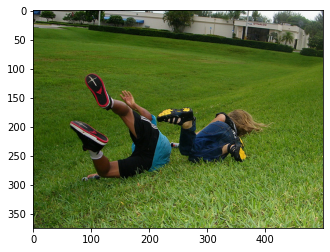

Caption: man in blue shirt is sitting on the grass with his hands in the air
_____________________________________
Images\3587009091_37188fd07e.jpg


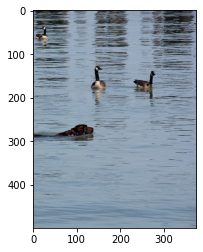

Caption: black dog is swimming in the water
_____________________________________
Images\3587077732_0933f1677b.jpg


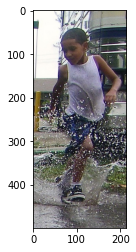

Caption: young boy is playing with fountain in the ocean
_____________________________________
Images\3587092143_c63030ed6d.jpg


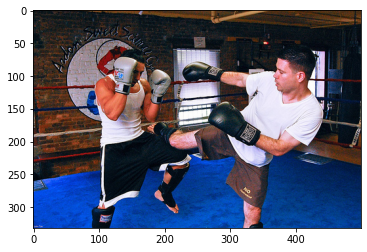

Caption: man in white shirt is performing trick on stage
_____________________________________
Images\3587449716_3bf1552c36.jpg


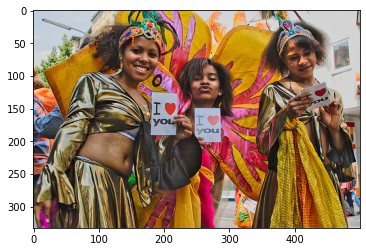

Caption: people are standing in front of some
_____________________________________


In [23]:
for z in range(400,405): # set higher to see more examples
    pic = list(encoding_test.keys())[z]
    image = encoding_test[pic].reshape((1,OUTPUT_DIM))
    print(os.path.join(root_captioning,'Images', pic))
    x=plt.imread(os.path.join(root_captioning,'Images', pic))
    plt.imshow(x)
    plt.show()
    print("Caption:",generateCaption(image))
    print("_____________________________________")